In [ ]:
#Importing Libraries11
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from tensorflow.keras.optimizers import Adam , RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Convolution2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization

In [ ]:
#Loading Train Data
train = pd.read_csv("/content/train.csv")
print(train.shape)
#train.head()

(42000, 785)


In [ ]:
# Replacing Nans by zero
train=train.fillna(0)
#train.isnull().sum()

In [ ]:
train.head(1).to_numpy

<bound method DataFrame.to_numpy of    label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0      1       0       0       0  ...         0         0         0         0

[1 rows x 785 columns]>

In [ ]:
train.isnull().values.any()

False

In [ ]:
#Loading test data
test= pd.read_csv("/content/test.csv")
print(test.shape)
#test.head()

(28000, 784)


In [ ]:
# Replacing Nans by zero
test=test.fillna(0)
#test.isnull().sum()

In [ ]:
#Seperating labels from train and converting int to float pixel values
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
Y_train = train.iloc[:,0].values.astype('int32') 

X_test = test.values.astype('float32')

In [ ]:
#Sacling the values to range 0 to 1
X_train = X_train / 255.0
X_test = X_test /255.0

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

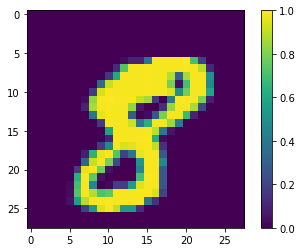

In [ ]:
#Visualizing the data
plotData= X_train.reshape(X_train.shape[0], 28, 28)
plt.figure()
plt.imshow(plotData[10])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
Y_train[10]

8

In [ ]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
#X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_train.shape

(42000, 28, 28, 1)

In [ ]:
#X_train[0]

In [ ]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
#X_test = X_test.reshape(X_test.shape[0], 28, 28)
X_test.shape

(28000, 28, 28, 1)

## Preprocessiong

#### Feature Standardisation 
Centring the data around zero mean and unit variance.

In [ ]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

#### One hot encoding on the labels 

In [ ]:
from keras.utils.np_utils import to_categorical
Y_train= to_categorical(Y_train)
num_classes = Y_train.shape[1]
num_classes

10

### Creating cross validation set

In [ ]:
X = X_train
Y = Y_train
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=42)

## Neural Network Model

### Model 1


In [ ]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)

In [ ]:
seed

43

In [ ]:
model= Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

input shape  (None, 28, 28, 1)
output shape  (None, 10)


In [ ]:
model.compile(optimizer=RMSprop(lr=0.001),
 loss='categorical_crossentropy',
 metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
gen = image.ImageDataGenerator()
#creating batches with real time data augmentation
batches = gen.flow(X_train, Y_train, batch_size=64)
val_batches=gen.flow(X_val, Y_val, batch_size=64)

In [ ]:
batches

In [ ]:
# Fitting the model
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
37800/37800 [==============================] - 2s 46us/step - loss: 0.4475 - accuracy: 0.8668 - val_loss: 0.3271 - val_accuracy: 0.9033


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_dict

{'accuracy': [0.8668254017829895],
 'loss': [0.4474690556526184],
 'val_accuracy': [0.903333306312561],
 'val_loss': [0.32713425159454346]}

In [ ]:
predictions = model.predict(X_test, verbose=0)
classes_x=np.argmax(predictions,axis=1)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": classes_x})
submissions.to_csv("model1.csv", index=False, header=True)

### Model 2:  Adding another layer

In [ ]:
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
fc = get_fc_model()
fc.optimizer.lr=0.01
history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
37800/37800 [==============================] - 3s 84us/step - loss: 0.3475 - accuracy: 0.9117 - val_loss: 0.2315 - val_accuracy: 0.9333


In [ ]:
history_dict = history.history
history_dict

{'accuracy': [0.9117460250854492],
 'loss': [0.347528338432312],
 'val_accuracy': [0.9333333373069763],
 'val_loss': [0.2315049022436142]}

In [ ]:
predictions = model.predict(X_test, verbose=0)
classes_x=np.argmax(predictions,axis=1)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": classes_x})
submissions.to_csv("model2.csv", index=False, header=True)

### Model 3: CNN

In [ ]:
def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model= get_cnn_model()
model.optimizer.lr=0.01

In [ ]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37800/37800 [==============================] - 79s 2ms/step - loss: 0.2566 - accuracy: 0.9260 - val_loss: 0.1120 - val_accuracy: 0.9679


In [ ]:
history_dict = history.history
history_dict

{'accuracy': [0.9260053038597107],
 'loss': [0.25657209753990173],
 'val_accuracy': [0.9678571224212646],
 'val_loss': [0.11201290041208267]}

In [ ]:
predictions = model.predict(X_test, verbose=0)
classes_x=np.argmax(predictions,axis=1)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": classes_x})
submissions.to_csv("model3.csv", index=False, header=True)

Data Augmentation

In [ ]:
gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, Y_train, batch_size=64)
val_batches = gen.flow(X_val, Y_val, batch_size=64)

In [ ]:
model.optimizer.lr=0.001
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

    1/37800 [..............................] - ETA: 1:35:59 - loss: 0.1845 - accuracy: 0.9219

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37800/37800 [==============================] - 89s 2ms/step - loss: 0.1347 - accuracy: 0.9587 - val_loss: 0.0911 - val_accuracy: 0.9707


In [ ]:
history_dict = history.history
history_dict

{'accuracy': [0.9586507678031921],
 'loss': [0.13474124670028687],
 'val_accuracy': [0.970714271068573],
 'val_loss': [0.09114781022071838]}

In [ ]:
predictions = model.predict(X_test, verbose=0)
classes_x=np.argmax(predictions,axis=1)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": classes_x})
submissions.to_csv("model4.csv", index=False, header=True)

#### Batch Normalization

In [ ]:
def get_bn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model= get_bn_model()
model.optimizer.lr=0.01
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37800/37800 [==============================] - 120s 3ms/step - loss: 0.2213 - accuracy: 0.9385 - val_loss: 0.0921 - val_accuracy: 0.9779


In [ ]:
model.optimizer.lr=0.01
gen = image.ImageDataGenerator()
batches = gen.flow(X, y, batch_size=64)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3)

In [ ]:
predictions = model.predict(X_test, verbose=0)
classes_x=np.argmax(predictions,axis=1)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": classes_x})
submissions.to_csv("model5.csv", index=False, header=True)

### Model 6

In [ ]:
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model  

In [ ]:
fc = get_fc_model()
fc.optimizer.lr=0.01
history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
37800/37800 [==============================] - 15s 385us/step - loss: 0.6854 - accuracy: 0.8056 - val_loss: 0.3861 - val_accuracy: 0.8855


In [ ]:
history_dict = history.history
history_dict

{'accuracy': [0.8055819869041443],
 'loss': [0.6853961944580078],
 'val_accuracy': [0.8854761719703674],
 'val_loss': [0.38614964485168457]}

In [ ]:
predictions = model.predict(X_test, verbose=0)
classes_x=np.argmax(predictions,axis=1)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": classes_x})
submissions.to_csv("model6.csv", index=False, header=True)

### Model 7

In [ ]:
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
